# Esercitazione 5
### Laboratorio di Simulazione Numerica

Il materiale relativo all'esercitazione cinque è suddiviso come segue nella cartella `Lab_05`: i codici sono raccolti nella cartella `Code/5.1` corrispondente alla consegna dell'esercitazione; i risultati relativi agli esercizi svolti sono raccolti nella cartella `Results`;

---

Il Jupyter Notebook è organizzato come segue:
- 5.0 caricamento dei pacchetti e introduzione;
- 5.1 stima di $\langle r \rangle_{\Psi_{100}}$ e $\langle r \rangle_{\Psi_{210}}$ e delle relative incertezze utilizzando simulazioni basate sull'algoritmo di Metropolis _aka_ $M(RT)^2$. 

## 5.0 - caricamento dei pacchetti e introduzione

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import tqdm as tqdm

sns.set_theme(font_scale=1.7, style='whitegrid') 

In [42]:
noequi = np.loadtxt("Results/noequi.dat")          # 10'000 passi senza equilibrare
equi = np.loadtxt("Results/equi.dat")              # 10'000 passi + 1'000 di equilibrazione 

In [87]:
H100 = np.loadtxt("Results/H100.dat")
H210 = np.loadtxt("Results/H210.dat")

###  L'algoritmo $M(RT)^2$ 

L'algoritmo di Metropolis permette di effettuare il campionamento statistico di una distribuzione di probabilità $P_{eq}$ di qualsiasi dimensione e indipendentemente dalla sua complessità analitica. Questo enorme vantaggio è dovuto all'idea di produrre un processo stocastico all'interno dello spazio campione, durante il quale ogni passo $x\to x'$ della catena viene  eseguito in accordo con la matrice $\Pi(x'|x)$, che è anche detta _nucleo stocastico_. Svolgendo un processo di questo tipo stiamo assumendo che la probabilità condizionata relativa ai due eventi successivi sia funzione soltanto di quest'ultimi.

Ai fini dell'implementazione di $M(RT)^2$ è utile scomporre il nucleo stocastico in due contributi fattorizzati: 

$$ \Pi (x'|x) = T(x'|x)\cdot A(x'|x),$$ 

in cui $T$ e $A$ sono dette rispettivamente matrice di trasferimento e matrice di accettazione. Le scelte che si possono fare nel definire le matrici coinvolte nel Metropolis possono essere molteplici; la più nota (che è anche quella implementata in questo esercizio) è la seguente: 

$$ A(x'|x)=\min (1, q(x'|x)), \qquad \texttt{con} \qquad q(x'|x)=\frac{T(x'|x)P_{eq}(x')}{T(x|x')P_{eq}(x)}\geq 0. $$

In sostanza, $T$ serve per generare il nuovo punto $x'$ nello spazio campione. A questo punto si valuta la probabilità $\alpha$ di accettazione del punto tramite $A(x'|x)$. Infine, si accetta $x'$ con probabilità $\alpha$.

---

### $P_{eq}$ sul quale lo applichiamo

La consegna di questo esercizio ci richiede di effettuare il campionamento delle distribuzioni di probabilità della posizione dell'elettrone attorno al nucleo dell'atomo di idrogeno nel caso in cui le funzioni d'onda corrispondano agli autostati di _ground state_ e primo stato eccitato, rispettivamente $\Psi_{100}, \Psi_{210}$:

$$
\Psi_{1,0,0}(r,\theta,\phi)=
\frac{a_0^{-3/2}}{\sqrt{\pi}} e^{-r/a_0} 
\qquad \texttt{e} \qquad 
\Psi_{2,1,0}(r,\theta,\phi)=
\frac{a_0^{-5/2}}{8}\sqrt{\frac{2}{\pi}} r e^{-r/2a_0} \cos(\theta),
$$

da cui le probabilità (che esprimo in questo caso in coordinate cartesiane): $|\Psi_{100}(x,y,z)|^2$ e $|\Psi_{210}(x,y,z)|^2$. Tramite l'algoritmo di metropolis otteniamo un campione di punti corrispondenti alle posizioni assunte dal _walker_ nel corso del suo cammino stocastico; al crescere del numero di punti il campione approssima asintoticamente la distribuzione di probabilità. Utilizzando questo stesso campione siamo dunque in grado di calcolare (utilizzando il metodo delle medie a blocchi) il valore di $\langle r \rangle_{\Psi_{100}}$ e $\langle r \rangle_{\Psi_{210}}$ richiesto dalla consegna.

---

## 5.1 - utilizzare $M(RT)^2$ per stimare $\langle r \rangle_{\Psi_{100}}$ e $\langle r \rangle_{\Psi_{210}}$

### Generalità del mio codice

L'algoritmo $M(RT)^2$ è implementato nella classe `metropolis.cpp/h`, al cui interno ho definito i metodi necessari per concretizzare la classe `Measure` che viene richiamata all'interno del metodo `blocking`. I punti nello spazio campione sono interpretati per mezzo della classe `Position`, i cui data membri sono le coordinate cartesiane di un punto nello spazio tridimensionale e tramite la quale è possibile accedere e modificare le coordinate, trasformarle in coordinate sferiche e svolgere dei passi casuali (uniformi o gaussiani) di lunghezza `stepsize` nello spazio 3D. 

Il cuore dell'algoritmo di Metropolis è descritto nel metodo `try_step()`, all'interno del quale:
1. il mio walker (interpretato da `Position _x`) viene sottoposto ad un passo (ad esempio `_x -> gaussian_step(stepsize)`);
2. la vecchia e la nuova posizione di `_x` vengono utilizzate per calcolare il valore della p.d.f. (che è $P_{eq}$) in quei punti: ad esempio `pdf -> eval(_x)`;
3. in modo analogo a quello esposto nei paragrafi precedenti, la nuova posizione viene accettata o rigettata.

Nello svolgimento dell'esercizio ho eseguito in ogni run $M=10^6$ volte il metodo `try_step()`.

### Equilibrare il processo

Uno dei problemi dell'algoritmo di $M(RT)^2$ consiste nel caso in cui l'_walker_ venga inizializzato in una posizione "scomoda" (troppo lontano dalla regione di massima densità della distribuzione che vogliamo campionare). Per visualizzare questa necessità ho provato ad eseguire la simulazione del _ground state_ dell'atomo di idrogeno inizializzando l'_walker_ nel punto di coordinate $x_0=(50,50,50)$ ed eseguendo $M=10^4$ passi estratti da una $T$ uniforme. Ho lasciato evolvere con e senza l'aggiunta di $N_{equi}=10^3$ passi di equilibrazione. Riporto il risultato nel grafico seguente.

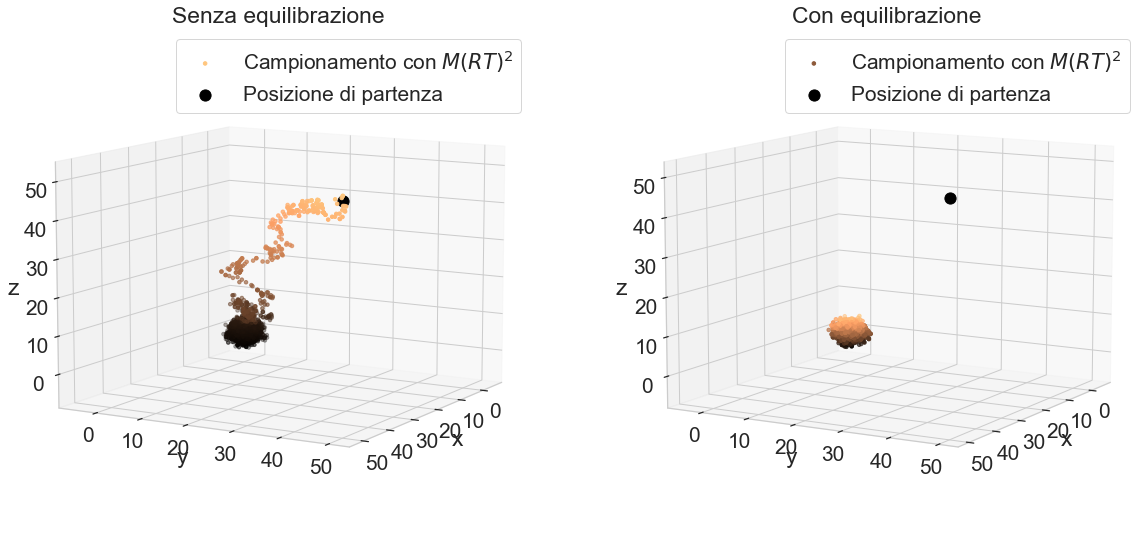

In [40]:
sns.set_theme(font_scale=1.9, style='whitegrid') 

X = noequi.T[0]
Y = noequi.T[1]
Z = noequi.T[2]

fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(1,2,1, projection='3d')
plt.title('Senza equilibrazione')
ax.scatter(X, Y, Z, c=Z, marker='.', s=50, label='Campionamento con $M(RT)^2$', cmap='copper')
ax.scatter(50,50,50, color='black', marker='.', s=500, label='Posizione di partenza')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 30)
plt.legend()

X = equi.T[0]
Y = equi.T[1]
Z = equi.T[2]

ax1 = fig.add_subplot(1,2,2, projection='3d')
plt.title('Con equilibrazione')
ax1.scatter(X, Y, Z, c=Z, marker='.', s=50, label='Campionamento con $M(RT)^2$', cmap='copper')
ax1.scatter(50,50,50, color='black', marker='.', s=500, label='Posizione di partenza')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.view_init(10, 30)
plt.legend()
plt.show()

__Figura 1:__ a sinistra, $M=10^4$ passi di Metropolis partendo da $x_0=(50,50,50)$ senza equilibrare il sistema. A destra una simulazione identica a cui ho aggiunto $N_{equi}=10^3$ passi di equilibrazione.

### Affrontare la correlazione tra i dati generati

Uno dei più grossi problemi dell'algoritmo di Metropolis è che si basa sulla generazione di una sequenza di passi che, intrinsecamente, contengono dunque un certo grado di correlazione. Proprio per evitare di utilizzare dei dati correlati (e quindi che ci priverebbero di informazioni importanti al fine della stima che stiamo cercando) utilizziamo anche in questa sede il metodo delle medie a blocchi. Andando ad effettuare misure distinte su blocchi di realizzazioni di un certo fenomeno, se scegliamo una dimensione opportunamente grande per i blocchi, riusciamo a risolvere il problema della correlazione. Per valutare con coscienza la dimensione più opportuna dei blocchi (per meglio dire la taglia $L=M/N$) con cui eseguire le misure eseguo il calcolo della funzione di autocorrelazione al crescere della dimensione del blocco di dati analizzato (analizzo il range $L\in[0,200]$).

Sconsiglio di eseguire la cella seguente, richiede un tempo $t\sim 9$ min.

In [52]:
AC = []
npoints = 200
Nstep = 1000000

print('Calcolo il valore della funzione di autocorrelazione')
for tau in tqdm.tqdm(range(npoints)):
    x_min_tau = H100[:Nstep - tau]
    x_plu_tau = H100[tau:]
    n = len(x_min_tau)
    AC.append((sum(x_min_tau * x_plu_tau)/n - sum(x_min_tau) / 
            n * sum(x_plu_tau) / n)/np.std(H100)**2)

  0%|          | 0/200 [00:00<?, ?it/s]

Calcolo il valore della funzione di autocorrelazione


100%|██████████| 200/200 [09:00<00:00,  2.70s/it]


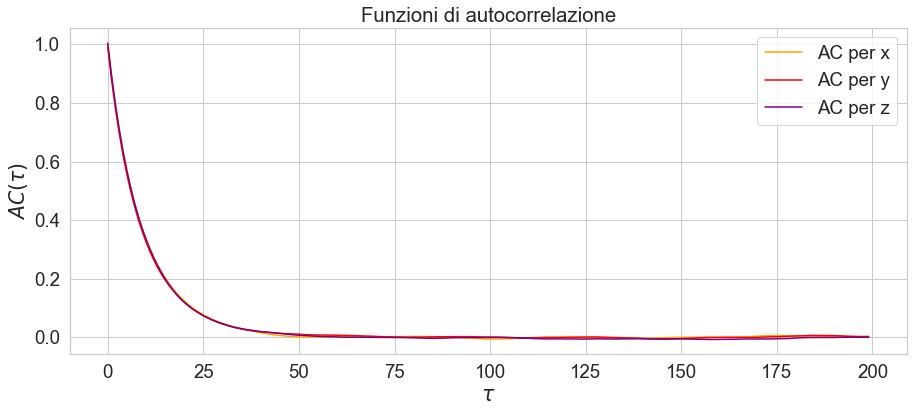

In [76]:
AC = np.asarray(AC)

plt.figure(figsize=(15,6))
plt.title('Funzioni di autocorrelazione')
plt.plot(AC.T[0], label='AC per x', color='orange')
plt.plot(AC.T[1], label='AC per y', color='red')
plt.plot(AC.T[2], label='AC per z', color='purple')
plt.legend()
plt.xlabel(r'$\tau$')
plt.ylabel(r'$AC(\tau)$')
plt.show()


### Eseguire i campionamenti utilizzando due diverse $T$

Adottate tutte queste precauzioni, siamo pronti infine per effettuare le stime richieste dalla consegna. Per farlo, eseguo due volte il codice, cambiando il tipo di passo che viene proposto in `try_step`, impostando una volta `method = "uniform"` e un'altra `method = "gaussian"`:
- __passo uniforme__, riporto solo la coordinata x a titolo d'esempio: `_x += Random -> Rannyu(-stepsize,stepsize)`.
- __passo gaussiano__, ancora una volta riporto x: `_x += Random -> Gauss(0, stepsize)`.

Per effettuare la stima dei valori di $\langle r \rangle_{\Psi_{100}}$ e $\langle r \rangle_{\Psi_{210}}$ ho utilizzato entrambi i metodi; in ognuno dei due casi ho eseguito $M=10^6$ realizzazioni (step) e selezionato $N=100$ blocchi. Questo valore di $N$, considerando anche l'alto numero di realizzazioni, mi permette di assumere che le stime sui blocchi siano effettuate su dati scorrelati. La singole realizzazione all'interno del metodo `blocking` è implementata eseguendo un passo del Metropolis e calcolando la distanza dall'origine tramite il metodo `get_radius()` implementato nella classe `Position`.

---

Ho dovuto eseguire una serie di tentativi prima di selezionare un valore di `stepsize` che mi garantisse il rispetto della regola empirica sull'accettazione, ossia che il rate di accettazione è bene sia intorno al 50%. 
- Per il ground state ho impostato `stepsize = 1.235`;
- per il primo stato eccitato invece `stepsize = 2.955`.

In [88]:
uni_block_100 = np.loadtxt("Results/uni_blockin_on_100.dat")
uni_block_210 = np.loadtxt("Results/uni_blockin_on_210.dat")

In [89]:
gau_block_100 = np.loadtxt("Results/gau_blockin_on_100.dat")
gau_block_210 = np.loadtxt("Results/gau_blockin_on_210.dat")

### Stime con blocking e passo uniforme

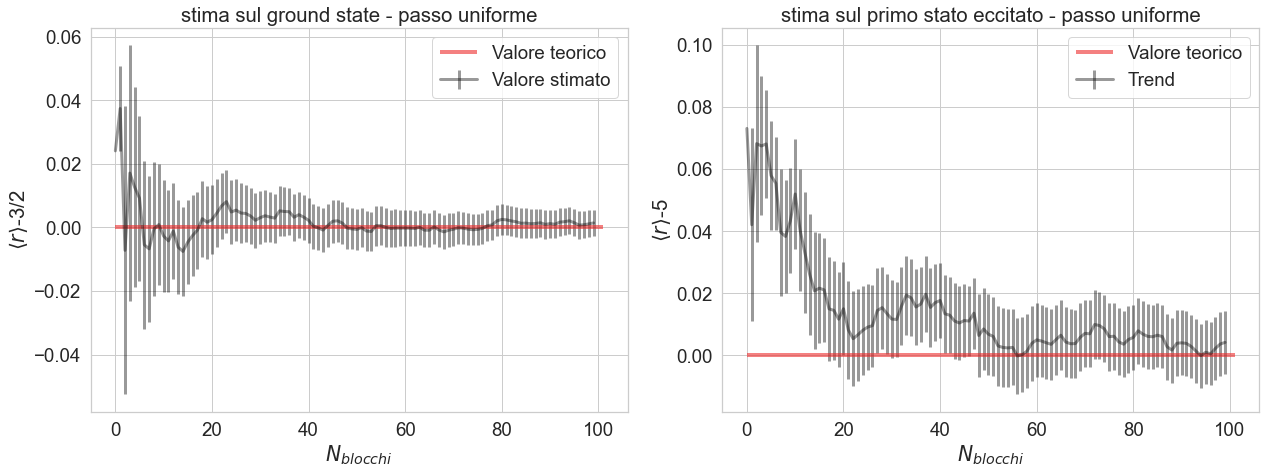

In [90]:
x = np.arange(100)

plt.figure(figsize=(18,7))

plt.subplot(1,2,1)
plt.title("stima sul ground state - passo uniforme")
plt.errorbar(x, uni_block_100.T[0]-1.5, yerr=uni_block_100.T[1], color='black', alpha=0.4, label='Valore stimato', linewidth=3)
plt.hlines(0,0,101, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=4, alpha=0.6)
plt.ylabel(r'$\langle r \rangle$-3/2')
plt.xlabel("$N_{blocchi}$")
plt.legend()

plt.subplot(1,2,2)
plt.title("stima sul primo stato eccitato - passo uniforme")
plt.errorbar(x, uni_block_210.T[0]-5, yerr=uni_block_210.T[1], color='black', alpha=0.4, label='Trend', linewidth=3)
plt.hlines(0,0,101, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=4, alpha=0.6)
plt.ylabel(r'$\langle r \rangle$-5')
plt.xlabel("$N_{blocchi}$")
plt.legend()

plt.tight_layout()
plt.savefig("block_on_hydro.png")
plt.show()

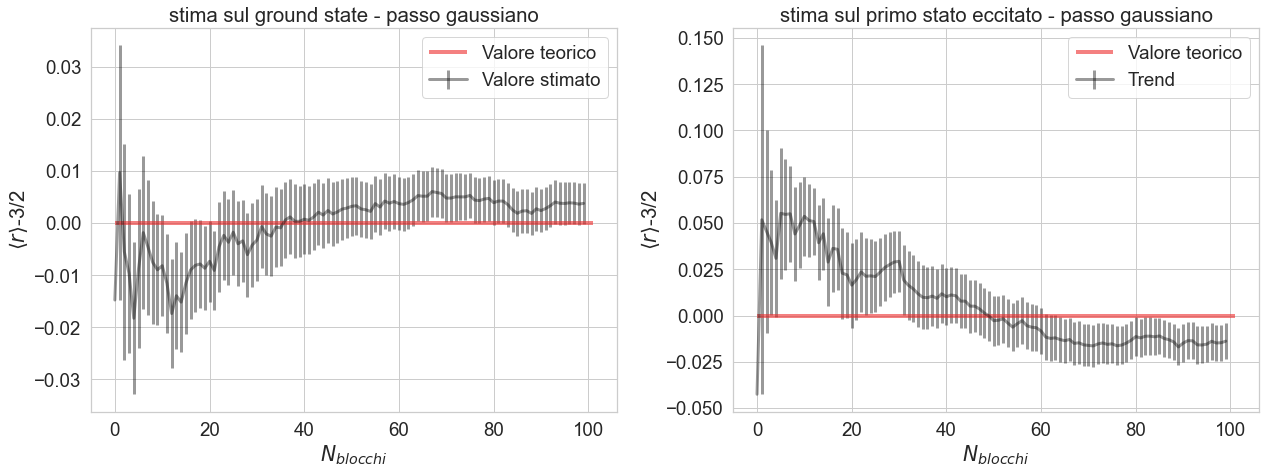

In [91]:
x = np.arange(100)

plt.figure(figsize=(18,7))

plt.subplot(1,2,1)
plt.title("stima sul ground state - passo gaussiano")
plt.errorbar(x, gau_block_100.T[0]-1.5, yerr=gau_block_100.T[1], color='black', alpha=0.4, label='Valore stimato', linewidth=3)
plt.hlines(0,0,101, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=4, alpha=0.6)
plt.ylabel(r'$\langle r \rangle$-3/2')
plt.xlabel("$N_{blocchi}$")
plt.legend()

plt.subplot(1,2,2)
plt.title("stima sul primo stato eccitato - passo gaussiano")
plt.errorbar(x, gau_block_210.T[0]-5, yerr=gau_block_210.T[1], color='black', alpha=0.4, label='Trend', linewidth=3)
plt.hlines(0,0,101, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=4, alpha=0.6)
plt.ylabel(r'$\langle r \rangle$-3/2')
plt.xlabel("$N_{blocchi}$")
plt.legend()

plt.tight_layout()
plt.savefig("block_on_hydro.png")
plt.show()

### Visualizziamo i campionamenti (step uniforme)

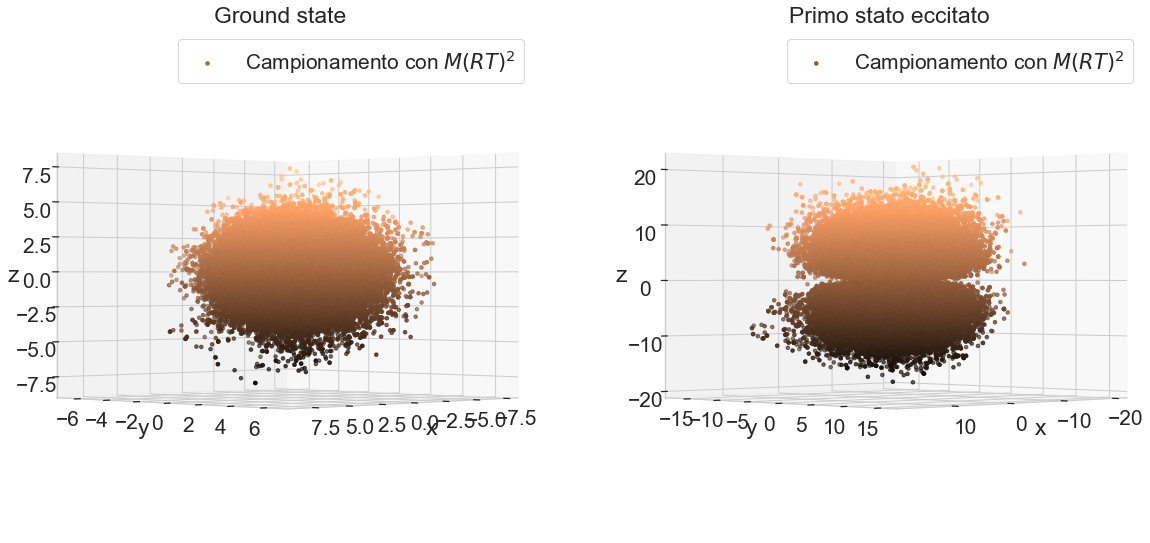

In [93]:
sns.set_theme(font_scale=1.9, style='whitegrid') 

X = H100.T[0]
Y = H100.T[1]
Z = H100.T[2]

fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(1,2,1, projection='3d')
plt.title('Ground state')
ax.scatter(X, Y, Z, c=Z, marker='.', s=50, label='Campionamento con $M(RT)^2$', cmap='copper')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(0, 45)
plt.legend()

X = H210.T[0]
Y = H210.T[1]
Z = H210.T[2]

ax1 = fig.add_subplot(1,2,2, projection='3d')
plt.title('Primo stato eccitato')
ax1.scatter(X, Y, Z, c=Z, marker='.', s=50, label='Campionamento con $M(RT)^2$', cmap='copper')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.view_init(0, 45)
plt.legend()
plt.show()